# initialize & load

In [1]:
from google.colab import drive
from google.colab import files

import numpy as np
import pandas as pd

from keras import models
from keras import layers
from keras.models import load_model

Using TensorFlow backend.


In [2]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
%cd ../content/gdrive/My Drive/projects/ggl_an/
%ls

/content/gdrive/My Drive/projects/ggl_an
model_LGB.sav  output_ens.csv  output_NN.csv  user_test_n.csv  user_train_n.csv
model_NN.h5    output_LGB.csv  user_test.csv  user_train.csv


In [4]:
%%time
filename = 'model_NN.h5'
model = load_model(filename)

df_train = pd.read_csv('user_train_n.csv', index_col = 0, dtype={'fullVisitorId': 'str'})
df_test = pd.read_csv('user_test_n.csv', index_col = 0, dtype={'fullVisitorId': 'str'})

df_y = df_train['transactionRevenue']
df_x = df_train.drop(['transactionRevenue'], axis=1)
df_tgt = df_test.drop(['transactionRevenue'], axis=1)

CPU times: user 11.6 s, sys: 1.43 s, total: 13.1 s
Wall time: 19 s


In [5]:
print(df_x.shape, df_y.shape, df_tgt.shape)

(714167, 37) (714167,) (617242, 37)


# train model

In [0]:
from keras import optimizers


def build_model(N_col):
  rate = 0.001
  model = models.Sequential()
  model.add(layers.Dense(N_col * 4, activation='relu', input_shape=(N_col,)))
  model.add(layers.Dense(100, activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(200, activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(100, activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(200, activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(100, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer=optimizers.adam(lr = rate), loss='mse', metrics=['mae'])
  return model

In [7]:
%%time
#epochs = 100
epochs = 500
batch_size = df_x.shape[0] // 4
validation_split = 0.1

model = build_model(df_x.shape[1])

history = model.fit(df_x,
                    df_y,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split = validation_split,
                    verbose=1)

Train on 642750 samples, validate on 71417 samples
Epoch 1/500
642750/642750 [==============================] - 3s 5us/step - loss: 8.4331 - mean_absolute_error: 0.4165 - val_loss: 8.5443 - val_mean_absolute_error: 0.6292
Epoch 2/500
642750/642750 [==============================] - 2s 3us/step - loss: 8.3502 - mean_absolute_error: 0.6192 - val_loss: 8.4783 - val_mean_absolute_error: 0.5323
Epoch 3/500
642750/642750 [==============================] - 2s 3us/step - loss: 8.2791 - mean_absolute_error: 0.5491 - val_loss: 8.3662 - val_mean_absolute_error: 0.5811
Epoch 4/500
642750/642750 [==============================] - 2s 3us/step - loss: 8.1479 - mean_absolute_error: 0.6205 - val_loss: 8.1822 - val_mean_absolute_error: 0.5426
Epoch 5/500
642750/642750 [==============================] - 2s 3us/step - loss: 7.9439 - mean_absolute_error: 0.5623 - val_loss: 7.9884 - val_mean_absolute_error: 0.6180
Epoch 6/500
642750/642750 [==============================] - 2s 3us/step - loss: 7.7371 - mean

# evaluate model

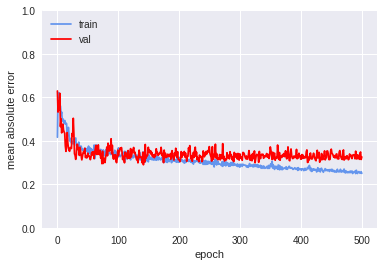

In [8]:
#dir(history)
#history.history

x = history.epoch
y = history.history['mean_absolute_error']
z = history.history['val_mean_absolute_error']

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(x, y, color='cornflowerblue', label = 'train')
plt.plot(x, z, color='red', label = 'val')
plt.legend(loc="upper left")
plt.ylim(0, 1)
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('mean absolute error')
plt.show()

In [9]:
%%time

from sklearn.metrics import mean_squared_error

pred = model.predict(df_x)
mse = mean_squared_error(df_y, pred)
rmse = np.sqrt(mse)
print(rmse)

1.5577345163747331
CPU times: user 30.5 s, sys: 5.04 s, total: 35.5 s
Wall time: 23.4 s


2.122997035400416

2.07703580318282

2.158526362017965

2.1637144539984035

1.8298523021188284

2.01942573754925

1.5577345163747331

In [10]:
%%time
model.save(filename)

#files.download(filename)

CPU times: user 199 ms, sys: 10.9 ms, total: 209 ms
Wall time: 230 ms


# predict & output

In [11]:
%%time
pred_tgt = model.predict(df_tgt)


CPU times: user 26.1 s, sys: 3.98 s, total: 30 s
Wall time: 19.7 s


In [12]:
%%time

pred_tgt[pred_tgt<0] = 0
df_out = pd.DataFrame(index = df_tgt.index)
df_out['PredictedLogRevenue'] = pred_tgt

df_out.to_csv('output_NN.csv')

CPU times: user 1.23 s, sys: 16.5 ms, total: 1.25 s
Wall time: 2.39 s


In [13]:
df_out.head()

,PredictedLogRevenue
fullVisitorId,
0000000259678714014,0.858212
0000049363351866189,0.006664
0000053049821714864,0.003702
0000059488412965267,0.026002
0000085840370633780,0.064352


In [14]:
df_out.describe()

,PredictedLogRevenue
count,617242.000000
mean,0.195547
std,1.414657
min,0.000000
25%,0.003840
50%,0.005478
75%,0.009249
max,170.747437
